# Feature importance analysis

In this notebook we analyse the importance of each SNP to the model using the [Integrated Gradients](https://arxiv.org/pdf/1703.01365.pdf) method. 

_Imports and configs_

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import explain_ensemble
# from diabnet.model import load
from diabnet.data import get_feature_names
from diabnet.ensemble import Ensemble
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
import pandas as pd
from pandas.plotting import parallel_coordinates

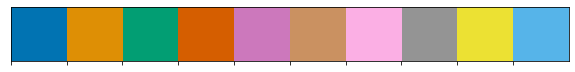

In [3]:
colors = sns.color_palette("colorblind")
sns.palplot(colors)
sns.set_style("whitegrid")
sns.set_style("ticks",{'axes.grid': True,'grid.color': '.95', 'grid.linestyle': '-'})

_load trained ensemble model_

In [4]:
ensemble = Ensemble('../results/models/positive/model-positive-21-adamw-lc7-2021-10-05')

In [5]:
feat_names = get_feature_names("../data/datasets/visits_sp_unique_test_positivo_1000_random_0.csv", use_sex=True, use_parents_diagnosis=True)

In [6]:
# DEBUG:
feat_names[-20:]

['snp_1_28265165',
 'snp_7_62322704',
 'snp_6_57432511',
 'snp_19_5147864',
 'snp_9_1667961',
 'snp_7_142786651',
 'snp_9_68692515',
 'snp_12_53198338',
 'snp_6_37571581',
 'snp_20_52032232',
 'snp_20_52032233',
 'snp_20_26104019',
 'snp_20_50189624',
 'snp_1_143276644',
 'snp_16_9536673',
 'snp_20_25734788',
 'AGE',
 'sex',
 'mo_t2d',
 'fa_t2d']

In [7]:
# feature attribution using training dataset
e_train = explain_ensemble.ExplainModel(ensemble, feat_names, "../data/datasets/visits_sp_unique_train_positivo_1000_random_0.csv")

In [8]:
# feature attribution using test dataset
e_test = explain_ensemble.ExplainModel(ensemble, feat_names, "../data/datasets/visits_sp_unique_test_positivo_1000_random_0.csv")

In [9]:
def feat_importance(values, age, sex):
    imp = values.calc_attr(age, sex)
    # testa se o SNP tem valores 1 ou 2. caso não tenha, sua importancia não pode ser calculada
    s = {k: [np.mean(imp[k]), np.median(imp[k])] for k in imp if len(imp[k]) > 0} 
    df = pd.DataFrame.from_dict(s, orient='index')
    df.rename(columns={0:f'{sex}{age}_mean', 1:f'{sex}{age}_median'}, inplace=True)
    # df.sort_values(by=0, ascending=False).head(50)
    return df
    

# Feature Importance

Qual a importância dos SNPs independentemente de outras características (sexo, diagnóstico dos pais, idade*).
*Para torna independente da idade fixamos a idade em 50.

In [126]:
age = -1
sex = 'X' # 'X' significa qualquer sexo

Não há um consenso se a análise de importância das características (feature importance) deve ser feita com os dados de teste ou treinamento. Nós testamos os dois...

In [127]:
df_feat_imp_50_X_train = feat_importance(e_train, -1, 'X')

In [128]:
df_feat_imp_50_X_test = feat_importance(e_test, -1, 'X')

No entanto, no conjunto de teste 44 dos 1000 SNPs não possuem o gene base do alelo recessivo (valores 1 ou 2) e consequentemente, não conseguimos atribuir um valor de importância. E como notamos pelo boxplot abaixo, boa parte deles podem ser importantes.

44 SNPs não tem valores no conjunto de teste


<AxesSubplot:ylabel='X-1_mean'>

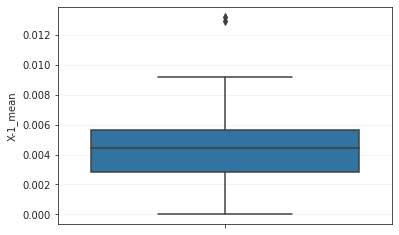

In [129]:
excluded = df_feat_imp_50_X_train[df_feat_imp_50_X_train.index.isin(df_feat_imp_50_X_test.index) == False]
print(f"{excluded.count()[0]} SNPs não tem valores no conjunto de teste")
sns.boxplot(y="X-1_mean", data=excluded)

In [130]:
df_feat_imp_50_X = df_feat_imp_50_X_train.join(df_feat_imp_50_X_test, how='inner', lsuffix='_train', rsuffix='_test')
df_feat_imp_50_X['SNP'] = df_feat_imp_50_X.index
# parallel_coordinates(tmp, '1_M50', cols='M50_mean','F50_mean'])
df_feat_imp_50_X = df_feat_imp_50_X.sort_values(by="X-1_mean_train")
df_feat_imp_50_X # apenas 956 pq 44 dos SNPs não tem valores 1 ou 2 no conjunto de teste 

,X-1_mean_train,X-1_median_train,X-1_mean_test,X-1_median_test,SNP
snp_16_19717582,-0.006830,0.0,-6.582737e-09,0.000000e+00,snp_16_19717582
snp_8_80259779,-0.006664,0.0,-4.206919e-03,0.000000e+00,snp_8_80259779
snp_20_24831146,-0.001060,0.0,-1.530159e-03,0.000000e+00,snp_20_24831146
snp_10_2847215,-0.001027,0.0,4.210574e-04,0.000000e+00,snp_10_2847215
snp_16_82889990,-0.000954,0.0,-3.462746e-04,0.000000e+00,snp_16_82889990
...,...,...,...,...,...
snp_5_127815045,0.012006,0.0,1.737348e-02,0.000000e+00,snp_5_127815045
snp_10_22459957,0.012126,0.0,5.168578e-03,0.000000e+00,snp_10_22459957
snp_18_56742728,0.012251,0.0,2.188780e-02,6.996403e-35,snp_18_56742728
snp_10_22347127,0.012433,0.0,6.337208e-03,0.000000e+00,snp_10_22347127


Comparando a média e a mediana da importância calculada para os conjuntos de treinamento e teste podemos ver que há uma correlação significativa (como esperado). Logo, optaremos por realizar as análises subsequentes apenas com a importância calculada no conjunto de treinamento.

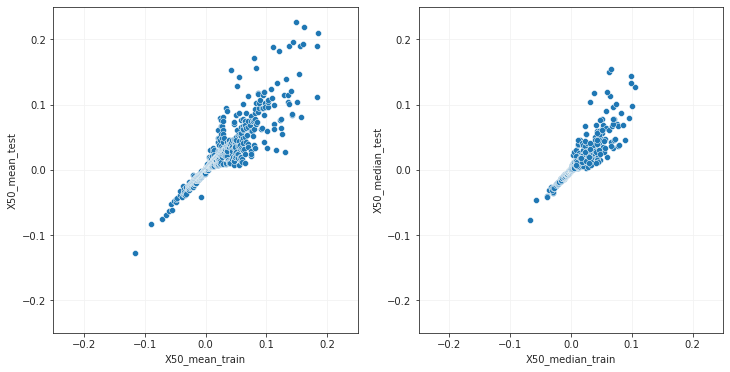

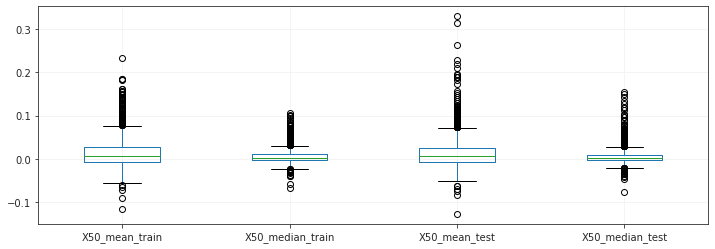

In [15]:
plt.figure(figsize=(12,6));
plt.subplot(121);
# plt.scatter(tmp.X50_mean_train.values, tmp.X50_mean_test.values);
sns.scatterplot(x="X_mean_train", y="X50_mean_test", data=df_feat_imp_50_X)
plt.ylim(-0.25,0.25)
plt.xlim(-0.25,0.25)
plt.subplot(122);
# plt.scatter(tmp.X50_median_train.values, tmp.X50_median_test.values);
sns.scatterplot(x="X50_median_train", y="X50_median_test", data=df_feat_imp_50_X)
plt.ylim(-0.25,0.25)
plt.xlim(-0.25,0.25)
plt.figure(figsize=(12,4));
df_feat_imp_50_X.boxplot();

<AxesSubplot:ylabel='X50_mean'>

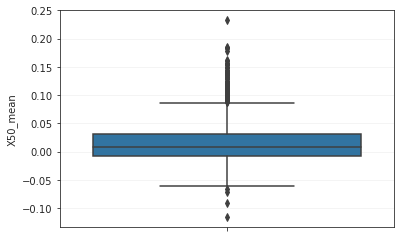

In [16]:
sns.boxplot(y="X50_mean", data=df_feat_imp_50_X_train)

In [17]:
df_feat_imp_50_X_train.describe()

,X50_mean,X50_median
count,1000.000000,1000.000000
mean,0.018075,0.007230
std,0.039063,0.019200
min,-0.116472,-0.067060
25%,-0.006992,-0.002258
50%,0.008736,0.002631
75%,0.030602,0.011333
max,0.233283,0.104763


In [18]:
df_feat_imp_50_X_train["chr"] = [int(s.split('_')[1]) for s in df_feat_imp_50_X_train.index]
df_feat_imp_50_X_train["pos"] = [float(s.split('_')[2]) for s in df_feat_imp_50_X_train.index]
df_feat_imp_50_X_train

,X50_mean,X50_median,chr,pos
snp_8_133462953,0.020974,0.005993,8,133462953.0
snp_2_91635413,0.008972,0.003117,2,91635413.0
snp_9_25963828,0.014833,0.008254,9,25963828.0
snp_1_17764169,0.019219,0.008390,1,17764169.0
snp_12_41767967,-0.002920,-0.000674,12,41767967.0
...,...,...,...,...
snp_20_26104019,0.021029,0.011064,20,26104019.0
snp_20_50189624,-0.009566,-0.005664,20,50189624.0
snp_1_143276644,-0.001373,-0.000275,1,143276644.0
snp_16_9536673,0.004992,0.000885,16,9536673.0


In [24]:
# df_feat_imp_50_X_train.to_csv("feat_importance_trainset_X50_lc7-2021-10-05.csv")

In [25]:
df_feat_imp_50_X_test

,X50_mean,X50_median
snp_8_133462953,0.049117,0.011453
snp_2_91635413,0.009254,0.003098
snp_9_25963828,0.013042,0.007296
snp_1_17764169,0.019391,0.008178
snp_12_41767967,-0.002897,-0.000780
...,...,...
snp_20_26104019,0.021541,0.010951
snp_20_50189624,-0.010491,-0.006090
snp_1_143276644,-0.000325,-0.000200
snp_16_9536673,0.004691,0.001069


O gráfico da atribuição dos SNPs separado por cromossomo (abaixo) mostra que os chr 1 e 3 

<AxesSubplot:xlabel='chr', ylabel='X50_mean'>

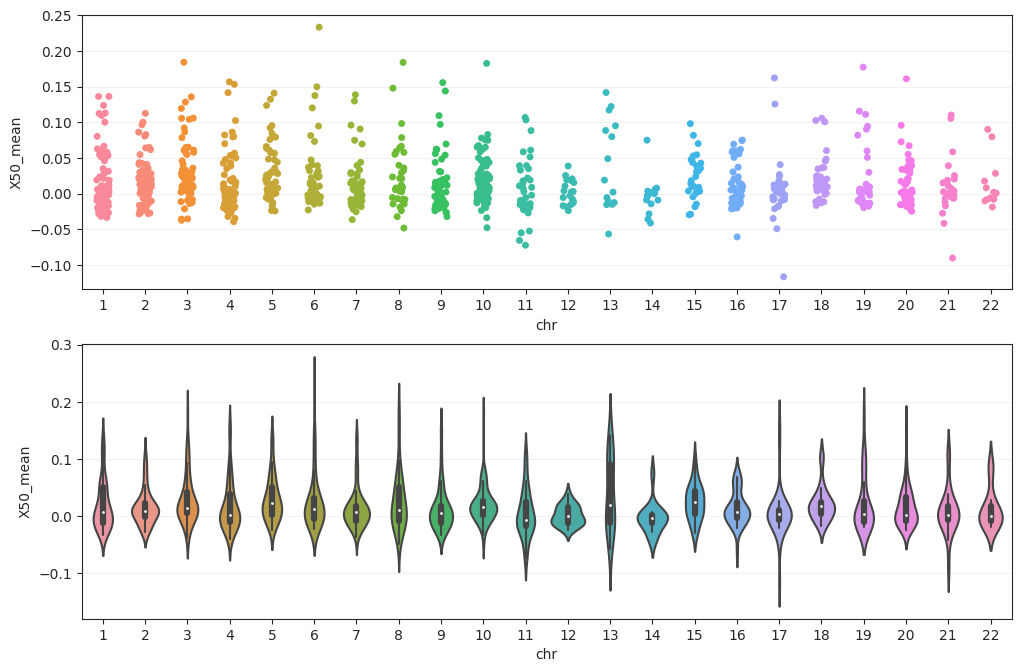

In [21]:
fig = plt.figure(figsize=(12,8), dpi=100)
plt.subplot(211)
sns.stripplot(x="chr", y="X50_mean", data=df_feat_imp_50_X_train, jitter=0.15)
plt.subplot(212)
sns.violinplot(x="chr", y="X50_mean", data=df_feat_imp_50_X_train, whis=np.inf)

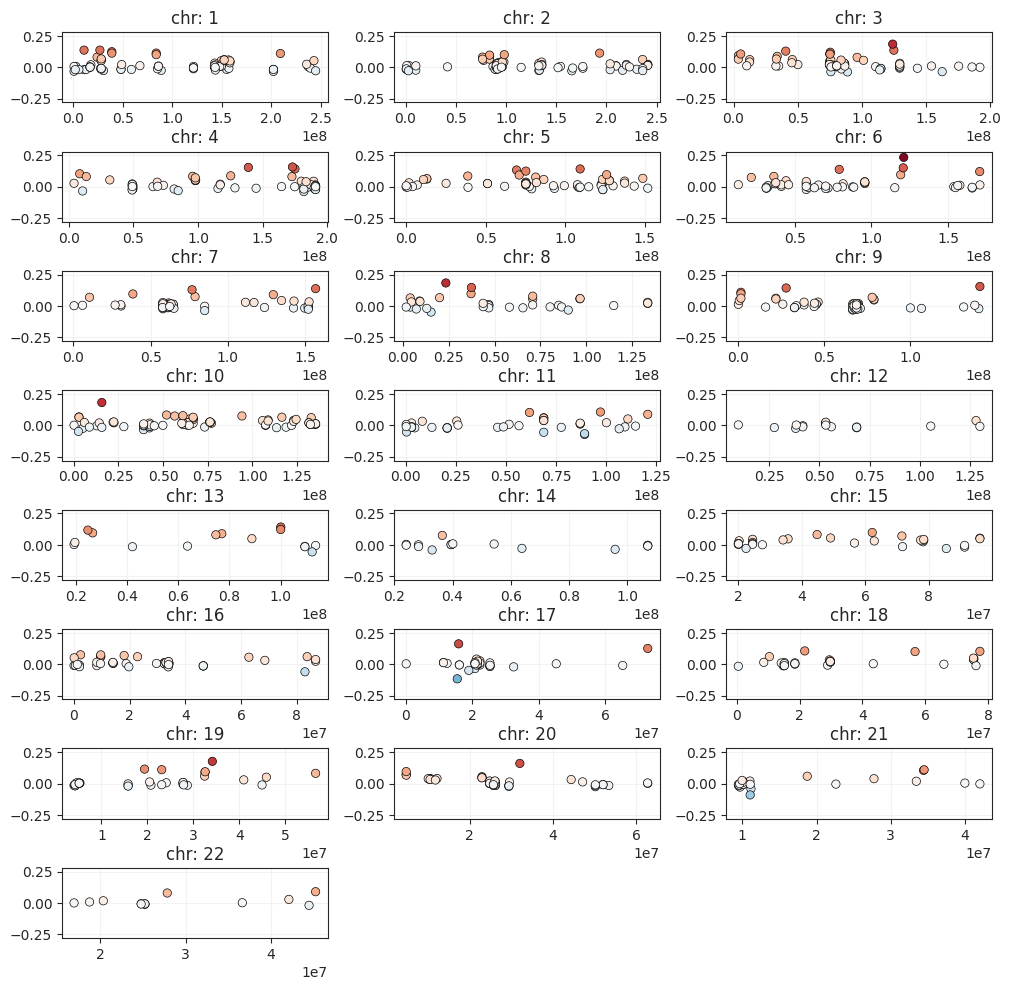

In [125]:
fig = plt.figure(figsize=(12,12), dpi=100)
plt.subplots_adjust(hspace=0.7, wspace=0.25)
for i in range(22):
    ax1=plt.subplot(8, 3, i+1)
    plt.title(f"chr: {i+1}")
    sns.scatterplot(x='pos', 
                    y="X50_mean", 
                    data=df_feat_imp_50_X_train[df_feat_imp_50_X_train["chr"]==i+1], 
                    hue="X50_mean", 
                    hue_norm=(-0.25,0.25), palette="RdBu_r", edgecolor="k")
    ax1.get_legend().remove()
    plt.ylim(-0.28,0.28)
    plt.ylabel("")
    plt.xlabel("")


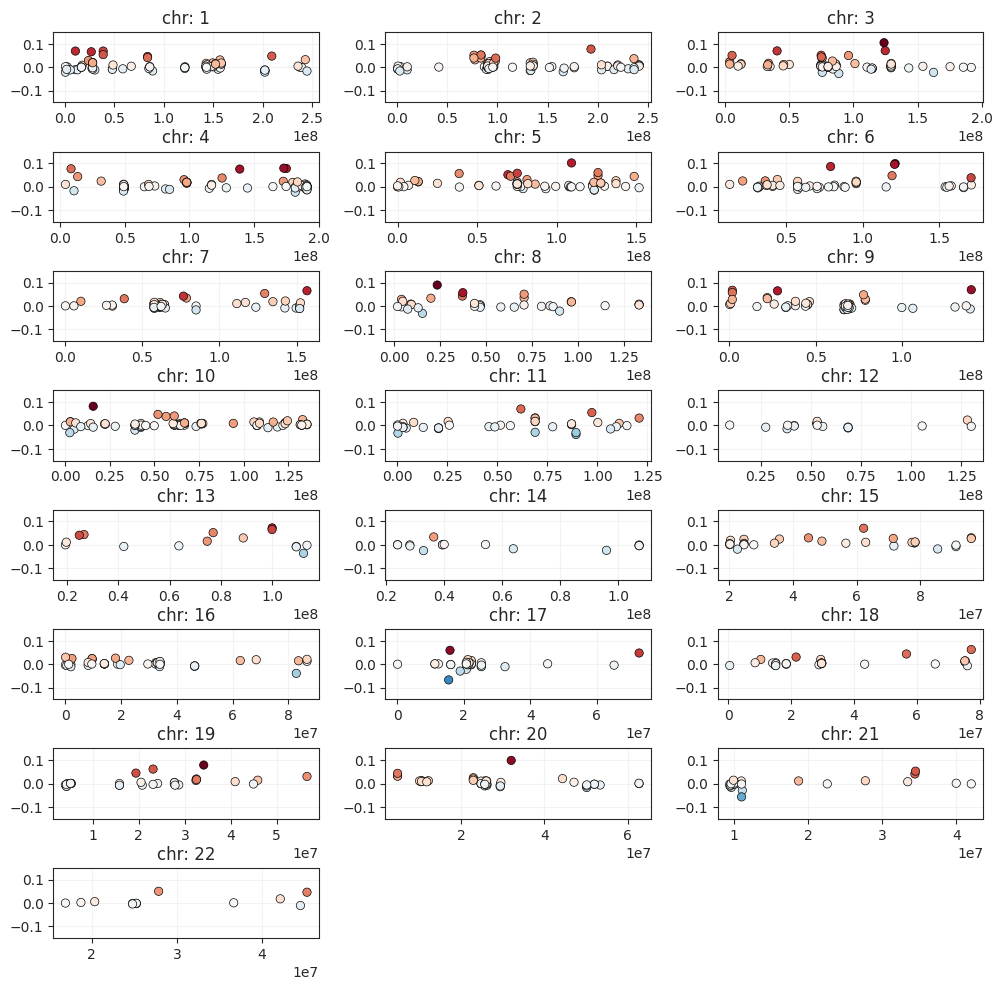

In [73]:
fig = plt.figure(figsize=(12,12), dpi=100)
plt.subplots_adjust(hspace=0.7, wspace=0.25)
for i in range(22):
    ax1=plt.subplot(8, 3, i+1)
    plt.title(f"chr: {i+1}")
    sns.scatterplot(x='pos', y="X50_median", data=df_feat_imp_50_X_train[df_feat_imp_50_X_train["chr"]==i+1], hue="X50_mean", hue_norm=(-0.18,0.18), palette="RdBu_r", edgecolor="k")
    ax1.get_legend().remove()
    plt.ylim(-0.15,0.15)
    plt.ylabel("")
    plt.xlabel("")

In [64]:
selection = df_feat_imp_50_X_train[abs(df_feat_imp_50_X_train['X50_mean'])> 2*df_feat_imp_50_X_train['X50_mean'].std()]

In [33]:
# selection.sort_values(by='X50_mean').to_csv("feature_importance.csv")

In [74]:
selection.sort_values(by='X50_mean', ascending=False).head(20)

,X50_mean,X50_median,chr,pos
snp_6_121073528,0.233283,0.098296,6,121073528.0
snp_3_123912059,0.184218,0.104763,3,123912059.0
snp_8_23479247,0.183924,0.089674,8,23479247.0
snp_10_15653813,0.182566,0.081810,10,15653813.0
snp_19_34109339,0.177343,0.079272,19,34109339.0
snp_17_15868329,0.162309,0.059311,17,15868329.0
snp_20_32074430,0.160917,0.099035,20,32074430.0
snp_4_172986805,0.156771,0.078772,4,172986805.0
snp_9_140296542,0.155728,0.069579,9,140296542.0
snp_4_138909352,0.153184,0.074962,4,138909352.0


In [70]:
selection_median = df_feat_imp_50_X_train[abs(df_feat_imp_50_X_train['X50_median'])> 2*df_feat_imp_50_X_train['X50_median'].std()]

In [71]:
selection_median.sort_values(by='X50_median', ascending=False)

,X50_mean,X50_median,chr,pos
snp_3_123912059,0.184218,0.104763,3,123912059.0
snp_5_109351989,0.140862,0.101239,5,109351989.0
snp_20_32074430,0.160917,0.099035,20,32074430.0
snp_6_121073528,0.233283,0.098296,6,121073528.0
snp_6_120756365,0.149807,0.095110,6,120756365.0
...,...,...,...,...
snp_2_98333598,0.100096,0.038938,2,98333598.0
snp_11_89308032,-0.072236,-0.038887,11,89308032.0
snp_16_82889990,-0.060624,-0.039135,16,82889990.0
snp_21_11058226,-0.090195,-0.056724,21,11058226.0


<AxesSubplot:xlabel='chr', ylabel='count'>

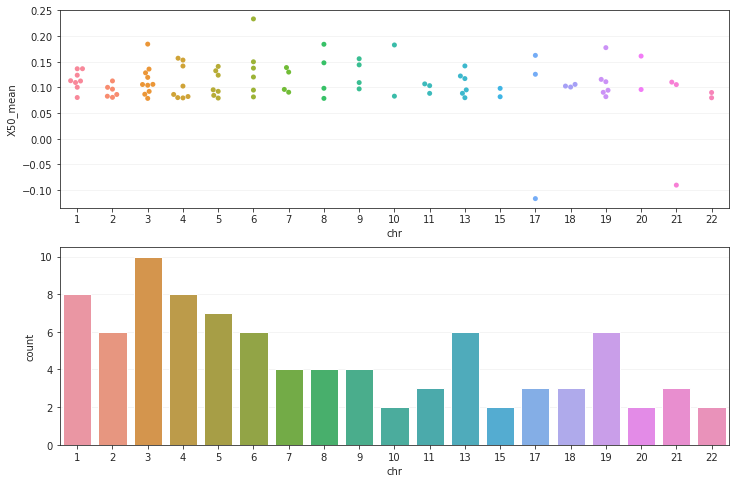

In [68]:
fig = plt.figure(figsize=(12,8))
plt.subplot(211)
# sns.stripplot(x="chr", y="X50_mean", data=selection, jitter=0.15)
sns.swarmplot(x="chr", y="X50_mean", data=selection)
plt.subplot(212)
# sns.barplot(x="chr", y="X50_mean", data=selection)
sns.countplot(x="chr", data=selection)

## Análise por sexo

In [36]:
# feature importance - M x F
# age: 50, set: test

In [45]:
df_feat_imp_50_M_train = feat_importance(e_train, 50, 'M')
df_feat_imp_50_F_train = feat_importance(e_train, 50, 'F')

In [46]:
df_feat_imp_50_FM_train = df_feat_imp_50_M_train.join(df_feat_imp_50_F_train, how='inner')
df_feat_imp_50_FM_train

,M50_mean,M50_median,F50_mean,F50_median
snp_8_133462953,0.022010,0.007446,0.020555,0.006055
snp_2_91635413,0.008751,0.003071,0.009091,0.003104
snp_9_25963828,0.014317,0.008125,0.015277,0.008488
snp_1_17764169,0.019141,0.008280,0.019188,0.008299
snp_12_41767967,-0.002487,-0.000756,-0.003228,-0.000645
...,...,...,...,...
snp_20_26104019,0.021588,0.011532,0.020474,0.010638
snp_20_50189624,-0.009914,-0.005963,-0.009282,-0.005504
snp_1_143276644,-0.001238,-0.000265,-0.001483,-0.000285
snp_16_9536673,0.005757,0.000940,0.004345,0.000814


In [ ]:
# tmp.sort_values(by="M50_mean").to_csv("feature_importance_sex.csv")

(-0.2, 0.35)

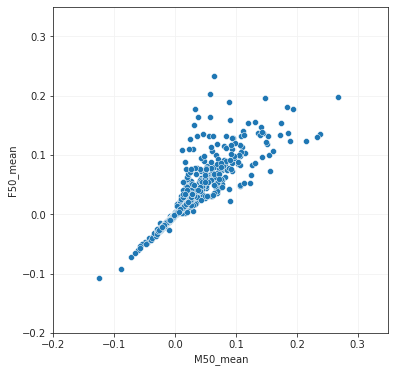

In [47]:
fig = plt.figure(figsize=(6,6))
sns.scatterplot(x="M50_mean", y="F50_mean", data=df_feat_imp_50_FM_train)
plt.ylim(-0.2,0.35)
plt.xlim(-0.2,0.35)

In [ ]:
# r² para os snps x sexo

(-0.2, 0.35)

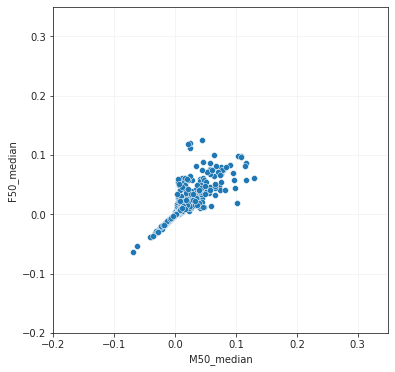

In [48]:
fig = plt.figure(figsize=(6,6))
sns.scatterplot(x="M50_median", y="F50_median", data=df_feat_imp_50_FM_train)
plt.ylim(-0.2,0.35)
plt.xlim(-0.2,0.35)

In [49]:
df_feat_imp_50_FM_train.sort_values(by="F50_mean").tail(20)

,M50_mean,M50_median,F50_mean,F50_median
snp_4_172986805,0.185040,0.094916,0.136925,0.069392
snp_4_174916149,0.144330,0.079384,0.137441,0.074949
snp_5_109351989,0.143391,0.107706,0.138766,0.096650
snp_13_100003066,0.111582,0.061173,0.140276,0.074210
snp_9_27901523,0.141301,0.064200,0.147184,0.065109
snp_19_32504936,0.030638,0.006372,0.149944,0.048611
snp_20_32074430,0.174615,0.102657,0.153982,0.097632
snp_7_156787327,0.120068,0.057846,0.154467,0.073887
snp_13_100042644,0.131891,0.067027,0.156386,0.081365
snp_19_23093093,0.090872,0.044267,0.158467,0.125950


In [75]:
df_feat_imp_50_FM_train.to_csv("feat_importance_trainset_FM50_lc7-2021-10-05.csv")

In [50]:
# tmp = feat_imp_M50.join(feat_imp_F50, how='inner')
df_feat_imp_50_FM_train_selection = df_feat_imp_50_FM_train[abs((df_feat_imp_50_FM_train['M50_mean']+df_feat_imp_50_FM_train['F50_mean']))/2 > 0.05]
df_feat_imp_50_FM_train_selection['SNP'] = df_feat_imp_50_FM_train_selection.index
# parallel_coordinates(tmp, '1_M50', cols='M50_mean','F50_mean'])
df_feat_imp_50_FM_train_selection.sort_values(by="M50_mean")

<ipython-input-50-b3cbf51b0057>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feat_imp_50_FM_train_selection['SNP'] = df_feat_imp_50_FM_train_selection.index


,M50_mean,M50_median,F50_mean,F50_median,SNP
snp_17_15464147,-0.125517,-0.069976,-0.108045,-0.063945,snp_17_15464147
snp_21_11058226,-0.088125,-0.061927,-0.092128,-0.053599,snp_21_11058226
snp_11_89308032,-0.072507,-0.040423,-0.071795,-0.038036,snp_11_89308032
snp_11_89308027,-0.065585,-0.030300,-0.065385,-0.030073,snp_11_89308027
snp_16_82889990,-0.061557,-0.039949,-0.059656,-0.037764,snp_16_82889990
...,...,...,...,...,...
snp_10_15653813,0.192885,0.083229,0.177474,0.079616,snp_10_15653813
snp_4_138909352,0.214334,0.115684,0.123478,0.057956,snp_4_138909352
snp_19_34109339,0.233382,0.129582,0.130298,0.060803,snp_19_34109339
snp_17_15868329,0.237788,0.074743,0.136059,0.053844,snp_17_15868329


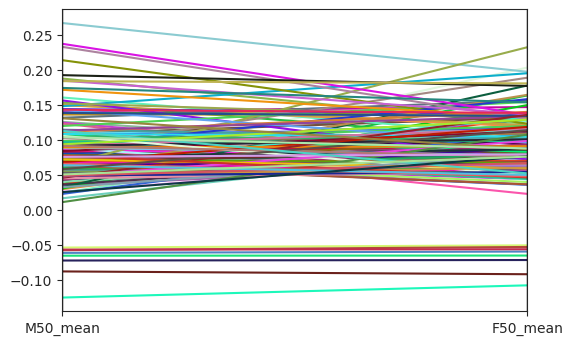

In [51]:
fig = plt.figure(dpi=100)
parallel_coordinates(df_feat_imp_50_FM_train_selection, 'SNP', cols=['M50_mean', 'F50_mean'] ).legend().remove() 

In [75]:
#j

# SNP Importance - Lifelong variability

In [69]:
df_feat_imp_by_age_train = feat_importance(e_train, 20, 'X') 
for age in range(30, 90, 10):
    df_feat_imp_by_age_train = df_feat_imp_by_age_train.join(feat_importance(e_train, age, 'X'),how='inner')

In [120]:
mask = np.array([(abs(df_feat_imp_by_age_train[f'X{age}_mean']) > 2*df_feat_imp_by_age_train[f'X{age}_mean'].std()).values for age in [20,30,40,50,60,70,80]])
count = np.sum(mask, axis=1)
mask = np.prod(mask, axis=0).astype(bool)

In [119]:
count

array([81, 82, 93, 89, 62, 57, 50])

In [121]:
# 164 snps with feat_importante > 2*std in at least one age
mask.sum()

2

<ipython-input-122-12501105aaae>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feat_imp_by_age_train_selection['SNP'] = df_feat_imp_by_age_train_selection.index


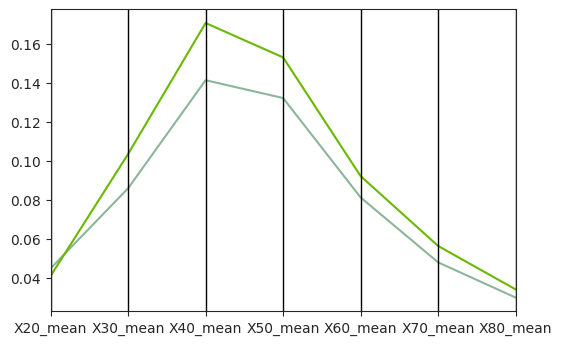

In [122]:
# mean

df_feat_imp_by_age_train_selection = df_feat_imp_by_age_train[mask]
df_feat_imp_by_age_train_selection['SNP'] = df_feat_imp_by_age_train_selection.index
fig = plt.figure(dpi=100)
parallel_coordinates(df_feat_imp_by_age_train_selection, 'SNP', cols=[i for i in df_feat_imp_by_age_train.columns if 'mean' in i]).legend().remove() 

In [123]:
df_feat_imp_by_age_train_selection

,X20_mean,X20_median,X30_mean,X30_median,X40_mean,X40_median,X50_mean,X50_median,X60_mean,X60_median,X70_mean,X70_median,X80_mean,X80_median,SNP
snp_5_69380555,0.045029,0.000141,0.086084,0.032636,0.141489,0.081612,0.132348,0.050933,0.081405,0.011405,0.048131,0.002770,0.030085,0.000934,snp_5_69380555
snp_4_138909352,0.041169,0.000028,0.103660,0.048637,0.170813,0.112613,0.153184,0.074962,0.092346,0.019106,0.056537,0.004442,0.034266,0.001501,snp_4_138909352


<ipython-input-76-142dff17a441>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feat_imp_by_age_train_selection['SNP'] = df_feat_imp_by_age_train_selection.index


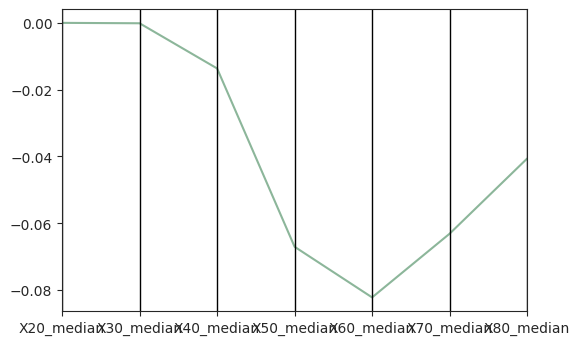

In [76]:
# median
df_feat_imp_by_age_train_selection = df_feat_imp_by_age_train[abs(df_feat_imp_by_age_train['X80_median']) > 0.02]
df_feat_imp_by_age_train_selection['SNP'] = df_feat_imp_by_age_train_selection.index
fig = plt.figure(dpi=100)
parallel_coordinates(df_feat_imp_by_age_train_selection, 'SNP', cols=[i for i in df_feat_imp_by_age_train.columns if 'median' in i]).legend().remove() 

In [55]:
# tmp = feat_imp_M50.join(feat_imp_F50, how='inner')
# tmp = tmp[abs((tmp['M50_mean']+tmp['F50_mean']))/2 > 0.04]
# tmp['SNP'] = tmp.index
# # parallel_coordinates(tmp, '1_M50', cols='M50_mean','F50_mean'])
# tmp.sort_values(by="M50_mean")

In [56]:
# fig = plt.figure(dpi=100)
# parallel_coordinates(tmp, 'SNP', cols=['M50_mean', 'F50_mean'])

In [57]:
# feat_imp_by_age = feat_importance(e_test, 20, 'X') 
# for age in range(30, 90, 10):
#     feat_imp_by_age = feat_imp_by_age.join(feat_importance(e_test, age, 'X'),how='inner')
    

In [58]:
# [i for i in feat_imp_by_age.columns if 'mean' in i]

In [59]:
# tmp = feat_imp_by_age[abs(feat_imp_by_age['X80_mean']) > 0.04]
# tmp['SNP'] = tmp.index
# parallel_coordinates(tmp, 'SNP', cols=[i for i in feat_imp_by_age.columns if 'mean' in i])

<AxesSubplot:>

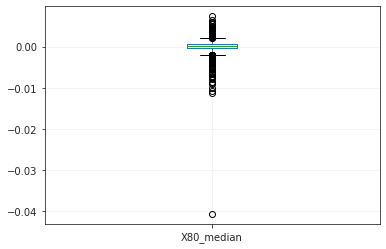

In [60]:
df_feat_imp_by_age_train[['X80_median']].boxplot()

In [61]:
feat_imp_M50.sort_values(by=0, ascending=False).head(50)

NameError: name 'feat_imp_M50' is not defined

In [ ]:
imp = e_test.calc_attr(20, 'X', samples_per_model=1)

In [ ]:
s

In [ ]:
dfnew.sort_values(by=0, ascending=True).head(50)

In [ ]:
import pandas as pd
dfnew = pd.DataFrame.from_dict(s, orient='index')
dfnew.sort_values(by=0, ascending=False).head(50)

In [ ]:
import pandas as pd
dfnew = pd.DataFrame.from_dict(s, orient='index')
dfnew.sort_values(by=0, ascending=False).head(50)

In [ ]:
import pandas as pd
df = pd.DataFrame.from_dict(s, orient='index')

In [ ]:
df.sort_values(by=0, ascending=True).head(50)

In [ ]:
df.sort_values(by=0, ascending=True).head(50)

In [ ]:
import numpy as np
np.mean(df.values, axis=0)

In [ ]:
df_20_X = e_train.attr_snps_mean(attrs, mask).rename(columns={0: "age=20,sex=X"})

In [ ]:
df_20_X.sort_values(by="age=20,sex=X", ascending=False).head(50)

In [ ]:
attr, mask = e_train.calc_attr(20, 'X', samples=1)
df_20_X = e_train.attr_snps_mean(attr, mask).rename(columns={0: "age=20,sex=X"})
attr, mask = e_train.calc_attr(20, 'M', samples=1)
df_20_M = e_train.attr_snps_mean(attr, mask).rename(columns={0: "age=20,sex=M"})
attr, mask = e_train.calc_attr(20, 'F', samples=1)
df_20_F = e_train.attr_snps_mean(attr, mask).rename(columns={0: "age=20,sex=F"})

In [ ]:
df_decay2 = df_20_X.sort_values(by="age=20,sex=X", ascending=False)
df_decay2.head(20)

In [ ]:
df_decay1 = df_20_X.sort_values(by="age=20,sex=X", ascending=False)
df_decay1.head(20)

In [ ]:
df_train[df_train.index=='snp_4_172986805']

In [ ]:
attr, mask = e_train.calc_attr(50, 'X', samples=1)
df_50_X = e_train.attr_snps_mean(attr, mask).rename(columns={0: "age=50,sex=X"})
attr, mask = e_train.calc_attr(50, 'M', samples=1)
df_50_M = e_train.attr_snps_mean(attr, mask).rename(columns={0: "age=50,sex=M"})
attr, mask = e_train.calc_attr(50, 'F', samples=1)
df_50_F = e_train.attr_snps_mean(attr, mask).rename(columns={0: "age=50,sex=F"})

In [ ]:
df_train = df_20_X.join([df_20_F,df_20_M,df_50_X,df_50_F,df_50_M])

In [ ]:
df_train.sort_values(by="age=20,sex=X", ascending=False).head(50)

In [ ]:
df_train.sort_values(by="age=50,sex=X", ascending=False).tail(50)

In [ ]:
plt.boxplot(df_20_X.values)

In [ ]:
attr, mask = e_test.calc_attr(20, 'X', samples=1)
df_20_X_test = e_test.attr_snps_mean(attr, mask).rename(columns={0: "age=20,sex=X"})
attr, mask = e_test.calc_attr(20, 'M', samples=1)
df_20_M_test = e_test.attr_snps_mean(attr, mask).rename(columns={0: "age=20,sex=M"})
attr, mask = e_test.calc_attr(20, 'F', samples=1)
df_20_F_test = e_test.attr_snps_mean(attr, mask).rename(columns={0: "age=20,sex=F"})

In [ ]:
attr, mask = e_test.calc_attr(50, 'X', samples=1)
df_50_X_test = e_test.attr_snps_mean(attr, mask).rename(columns={0: "age=50,sex=X"})
attr, mask = e_test.calc_attr(50, 'M', samples=1)
df_50_M_test = e_test.attr_snps_mean(attr, mask).rename(columns={0: "age=50,sex=M"})
attr, mask = e_test.calc_attr(50, 'F', samples=1)
df_50_F_test = e_test.attr_snps_mean(attr, mask).rename(columns={0: "age=50,sex=F"})

In [ ]:
df_test = df_20_X_test.join([df_20_F_test,df_20_M_test,df_50_X_test,df_50_F_test,df_50_M_test])

In [ ]:
df_test.sort_values(by="age=20,sex=X", ascending=False).head(50)

In [ ]:
df_test.sort_values(by="age=20,sex=X", ascending=False).tail(50)

In [ ]:
df = df_train.join(df_test, lsuffix='_train', rsuffix='_test')

In [ ]:
sns.pairplot(df.sort_values(by="age=20,sex=X_train", ascending=False).head(20))
# plt.savefig('pairplot.svg')

In [ ]:
df.sort_values(by="age=20,sex=X_train", ascending=False).head(20)

In [ ]:
df_sel = df.reindex(df["age=20,sex=X_train"].abs().sort_values(ascending=False).index).head(100)

In [ ]:
df_sel

In [ ]:
tmp = dict(Counter([s[:s.index('_',4)] for s in list(df_sel.index)]))
sns.barplot(x=list(tmp.keys()), y=list(tmp.values()))

In [ ]:
df_not_sel = df.reindex(df["age=20,sex=X_train"].abs().sort_values(ascending=False).index).tail(500)

In [ ]:
Counter([s[:s.index('_',4)] for s in list(df_not_sel.index)])

In [ ]:
list(tmp.values())

In [ ]:
plt.subplot(141)
plt.title("Precision")
plt.barh(y=list(tmp.keys()),width=list(tmp.values()))
# plt.xlim(0,1)
plt.subplot(142)
plt.title("Recall")
plt.barh(y=list(tmp.keys()),width=list(tmp.values()))
# plt.xlim(0,1)
plt.yticks([])
plt.subplot(143)
plt.title("F1-Score")
plt.barh(y=list(tmp.keys()),width=list(tmp.values()))
# plt.xlim(0,1)
plt.yticks([])
plt.subplot(144)
plt.title("Frequency")
plt.barh(y=list(tmp.keys()),width=list(tmp.values()))
plt.xscale('log')
plt.yticks([])

In [ ]:
feat_imp_M50.sort_values(by='M50_mean')

In [ ]:
feat_imp_M50.sort_values(by='M50_mean')

In [ ]:
plt.boxplot(feat_imp_M50['M50_mean'])

In [ ]:
df_test = pd.read_csv("../datasets/visits_sp_unique_test_positivo_1000_random_0.csv")

In [ ]:
df_train = pd.read_csv("../datasets/visits_sp_unique_train_positivo_1000_random_0.csv")

In [ ]:
c1 = df_test.columns
c2 = df_train.columns
for i in range(1009):
    if c1[i] != c2[i]:
        print(f"{c1[i]} = {c2[i]}")
    

In [ ]:
a = np.arange(-10,10)

In [ ]:
a

In [ ]:
plt.scatter(x=1,y=a)

In [100]:
# comparação entre lc[1-7]

In [45]:
df_tmp_lc1 = pd.read_csv("./feat_importance_trainset_X50_lc5-2021-10-05.csv")

In [48]:
df_tmp_lc2 = pd.read_csv("./feat_importance_trainset_X50_lc2-2021-10-05.csv")

/home/ABTLUS/jose.pereira/projects/diabnet/.venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='X50_mean', ylabel='X50_mean'>

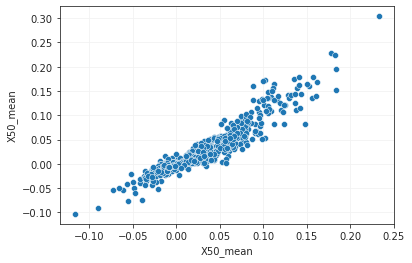

In [35]:
sns.scatterplot(df_tmp_lc1['X50_mean'], df_tmp_lc2['X50_mean'])

In [32]:
from scipy import stats

In [49]:
stats.pearsonr(df_tmp_lc1['X50_mean'], df_tmp_lc2['X50_mean'])

(0.8107722170535705, 2.4135376607139217e-234)

In [57]:
df_tmps = [pd.read_csv(f"./feat_importance_trainset_X50_lc{i}-2021-10-05.csv") for i in range(1,8)]
    

In [58]:
for i in range(len(df_tmps)):
    for j in range(i+1, len(df_tmps)):
        print(i+1,j+1)
        print(stats.pearsonr(df_tmps[i]['X50_mean'], df_tmps[j]['X50_mean']))
        print(stats.pearsonr(df_tmps[i]['X50_median'], df_tmps[j]['X50_median']))

1 2
(0.8910121842001162, 0.0)
(0.8755484359438299, 1.432342e-317)
1 3
(0.956813114235611, 0.0)
(0.9462672453935381, 0.0)
1 4
(0.9604305908450931, 0.0)
(0.9435928630190454, 0.0)
1 5
(0.9426906768453048, 0.0)
(0.9288236265638764, 0.0)
1 6
(0.8116676227825552, 2.8934450362034133e-235)
(0.6563018267681285, 3.0734484828298517e-124)
1 7
(0.8258982401835635, 1.3265483193217244e-250)
(0.6802804089026636, 8.211654207244419e-137)
2 3
(0.9671360622455033, 0.0)
(0.9604029016405374, 0.0)
2 4
(0.9369799759104139, 0.0)
(0.9209621522494335, 0.0)
2 5
(0.8107722170535705, 2.4135376607139217e-234)
(0.7743813349454457, 1.3230995276230274e-200)
2 6
(0.9432305343584576, 0.0)
(0.8789053600568947, 4e-323)
2 7
(0.9423167977095194, 0.0)
(0.8801720057150273, 0.0)
3 4
(0.9760799860067645, 0.0)
(0.9664929754024189, 0.0)
3 5
(0.8950907909925969, 0.0)
(0.8715685639472299, 3.307427338848e-311)
3 6
(0.888961374265859, 0.0)
(0.7717827343195489, 1.9373100429569043e-198)
3 7
(0.8921314618927315, 0.0)
(0.7777449061889354,

/home/ABTLUS/jose.pereira/projects/diabnet/.venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='X50_mean', ylabel='X50_mean'>

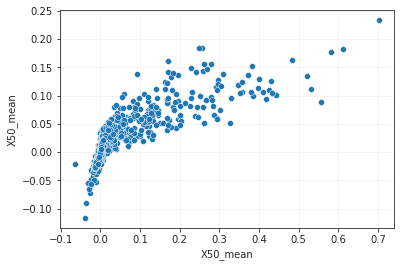

In [62]:
sns.scatterplot(df_tmps[0]['X50_mean'], df_tmps[6]['X50_mean'])

In [63]:
df_tmps[6]['X50_mean'].describe()

count    1000.000000
mean        0.018075
std         0.039063
min        -0.116472
25%        -0.006992
50%         0.008736
75%         0.030602
max         0.233283
Name: X50_mean, dtype: float64